# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before\
    a. Monomers (writes *results_mol.pkl*, and *mol_info.pkl*)\
    b. Dimers (writes *results_dim.pkl*)\
    c. Refs values from quantum chemistry, written in *Refs.cvs*

2. Analyze molecules, QMC versus DFT

3. Analyze dimers binding energies \
    a. Do extrapolations w/ w/o Jopt on molecules \
    b. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [1]:
import os
import re
import math

equil_time_au = 10.
#pickunits = 'au'
pickunits = 'kcal/mol'


units = { 'au':1, 'eV':2, 'kcal/mol':3,
        'au/atom':4, 'eV/atom':5, 'kcal/mol/atom':6 }

conv2au = {
        'au':1.0,
        'eV':27.21138505,
        'kcal/mol':627.503,
        'kJ/mol':2625.5,
        'cm^-1':219474.63,
        'K': 315777.,
        'J': 43.60E-19,
        'Hz':6.57966E+15,
        }

results = {}

#os.getcwd()
dir_analysis = '/Users/zen/Dropbox/WORK/2021_S66/ANALYSIS/'
datadir = dir_analysis +'/../DATA_CAM/'

#reblockexe = '/Users/zen/CASINO/bin_qmc//utils/macos-gnu-parallel.Andreas-iMac/reblock'
reblockexe = '/Users/zen/CASINO/bin_qmc/utils/macos-gnu-parallel.Andreas-MacBook-Pro-2021/reblock'


mol_names = ( 
'AcNH2',
'AcOH',
'Benzene',
'Cyclopentane',
'Ethene',
'Ethyne',
'MeNH2',
'MeOH',
'Neopentane',
'Pentane',
'Peptide',
'Pyridine',
'Uracil',
'Water'
)

In [2]:
import pandas as pd
from io import StringIO
import numpy as np

table_refs = '''
name	Hobza_1	Hobza_2	Martin_newBronze	Martin_Silver	Martin_Gold	Martin_CCSDT(Q)
01_Water-Water.xyz	4.92	-5.01	4.915	4.982	4.979	
02_Water-MeOH.xyz	5.59	-5.70	5.589	5.666	5.666	
03_Water-MeNH2.xyz	6.91	-7.04	6.894	6.986	6.985	
04_Water-Peptide.xyz	8.1	-8.22	8.089	8.183	na	
05_MeOH-MeOH.xyz	5.76	-5.85	5.773	5.822	5.824	
06_MeOH-MeNH2.xyz	7.55	-7.67	7.558	7.617	7.625	
07_MeOH-Peptide.xyz	8.23	-8.34	8.255	8.307	na	
08_MeOH-Water.xyz	5.01	-5.09	5.023	5.064	5.065	
09_MeNH2-MeOH.xyz	3.06	-3.11	3.029	3.087	3.088	
10_MeNH2-MeNH2.xyz	4.16	-4.22	4.127	4.184	4.189	
11_MeNH2-Peptide.xyz	5.42	-5.48	5.387	5.436	na	
12_MeNH2-Water.xyz	7.27	-7.40	7.259	7.349	7.354	
13_Peptide-MeOH.xyz	6.19	-6.28	6.213	6.251	na	
14_Peptide-MeNH2.xyz	7.45	-7.56	7.478	7.516	na	
15_Peptide-Peptide.xyz	8.63	-8.72	8.673	8.689	na	
16_Peptide-Water.xyz	5.12	-5.20	5.146	5.18	na	
17_Uracil-Uracil_BP.xyz	17.18	-17.45	17.432	17.407	na	
18_Water-Pyridine.xyz	6.86	-6.97	6.872	6.927	na	
19_MeOH-Pyridine.xyz	7.41	-7.51	7.451	7.467	7.464	
20_AcOH-AcOH.xyz	19.09	-19.41	19.328	19.361	19.364	
21_AcNH2-AcNH2.xyz	16.26	-16.52	16.441	16.474	16.468	
22_AcOH-Uracil.xyz	19.49	-19.78	19.732	19.736	na	
23_AcNH2-Uracil.xyz	19.19	-19.47	19.419	19.42	na	
24_Benzene-Benzene_pi-pi.xyz	2.82	-2.72	2.634	2.685	na	2.550
25_Pyridine-Pyridine_pi-pi.xyz	3.9	-3.80	3.716	3.751	na	
26_Uracil-Uracil_pi-pi.xyz	9.83	-9.75	9.765	9.672	na	
27_Benzene-Pyridine_pi-pi.xyz	3.44	-3.34	3.265	3.3	na	
28_Benzene-Uracil_pi-pi.xyz	5.71	-5.59	5.588	5.517	na	
29_Pyridine-Uracil_pi-pi.xyz	6.82	-6.70	6.698	6.629	na	
30_Benzene-Ethene.xyz	1.43	-1.36	1.31	1.358	1.348	1.234
31_Uracil-Ethene.xyz	3.38	-3.33	3.3	3.291	na	
32_Uracil-Ethyne.xyz	3.74	-3.69	3.649	3.651	na	
33_Pyridine-Ethene.xyz	1.87	-1.80	1.764	1.779	1.79	
34_Pentane-Pentane.xyz	3.78	-3.76	3.734	3.741	na	
35_Neopentane-Pentane.xyz	2.61	-2.60	2.59	2.582	na	
36_Neopentane-Neopentane.xyz	1.78	-1.76	1.753	1.745	na	
37_Cyclopentane-Neopentane.xyz	2.4	-2.40	2.384	2.376	na	
38_Cyclopentane-Cyclopentane.xyz	3	-2.99	2.971	2.967	na	
39_Benzene-Cyclopentane.xyz	3.58	-3.51	3.496	3.488	na	
40_Benzene-Neopentane.xyz	2.9	-2.85	2.839	2.824	na	
41_Uracil-Pentane.xyz	4.85	-4.81	4.792	4.761	na	
42_Uracil-Cyclopentane.xyz	4.14	-4.09	4.094	4.052	na	
43_Uracil-Neopentane.xyz	3.71	-3.69	3.678	3.652	na	
44_Ethene-Pentane.xyz	2.01	-1.99	1.948	1.973	na	
45_Ethyne-Pentane.xyz	1.75	-1.72	1.669	1.696	na	
46_Peptide-Pentane.xyz	4.26	-4.26	4.195	4.215	na	
47_Benzene-Benzene_TS.xyz	2.88	-2.83	2.823	2.801	na	
48_Pyridine-Pyridine_TS.xyz	3.83	-3.51	3.492	3.472	na	
49_Benzene-Pyridine_TS.xyz	3.33	-3.29	3.28	3.26	na	
50_Benzene-Ethyne_CH-pi.xyz	2.87	-2.86	2.822	2.828	2.839	
51_Ethyne-Ethyne_TS.xyz	1.52	-1.54	1.506	1.519	1.526	
52_Benzene-AcOH_OH-pi.xyz	4.71	-4.73	4.661	4.691	na	
53_Benzene-AcNH2_NH-pi.xyz	4.36	-4.40	4.346	4.376	na	
54_Benzene-Water_OH-pi.xyz	3.28	-3.29	3.212	3.267	na	
55_Benzene-MeOH_OH-pi.xyz	4.19	-4.17	4.106	4.139	na	
56_Benzene-MeNH2_NH-pi.xyz	3.23	-3.20	3.153	3.174	na	
57_Benzene-Peptide_NH-pi.xyz	5.28	-5.26	5.22	5.222	na	
58_Pyridine-Pyridine_CH-N.xyz	4.15	-4.24	4.194	4.189	na	
59_Ethyne-Water_CH-O.xyz	2.85	-2.93	2.883	2.905	2.912	
60_Ethyne-AcOH_OH-pi.xyz	4.87	-4.97	4.863	4.917	4.925	
61_Pentane-AcOH.xyz	2.91	-2.91	2.839	2.876	na	
62_Pentane-AcNH2.xyz	3.53	-3.53	3.458	3.491	na	
63_Benzene-AcOH.xyz	3.8	-3.75	3.715	3.709	na	
64_Peptide-Ethene.xyz	3	-3.00	2.945	2.967	na	
65_Pyridine-Ethyne.xyz	3.99	-4.10	4.065	4.064	na	
66_MeNH2-Pyridine.xyz	3.97	-3.97	3.907	3.93	na	
'''

df_refs = pd.read_table( StringIO( table_refs ) )
df_refs.Hobza_2 = -df_refs.Hobza_2
df_refs.index = range(1,67)
df_refs.loc[ df_refs.Martin_Gold == 'na', 'Martin_Gold' ] = np.NaN
for i in df_refs.name:
    new = i[:-4]
    new = new.replace('_',' ')
    #print(new)
    df_refs.loc[ df_refs.name==i , 'name' ] = new
#type( df_refs.iloc[0,1] )

for i in df_refs.columns:
    print(i)
    if i != 'name':
        for j in df_refs.index:
            if df_refs.loc[j,i] is not np.NaN:
                df_refs.loc[j,i] = -float(df_refs.loc[j,i])


df_refs.to_csv( 'Refs.csv' )

df_refs

name
Hobza_1
Hobza_2
Martin_newBronze
Martin_Silver
Martin_Gold
Martin_CCSDT(Q)


/Users/zen/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,name,Hobza_1,Hobza_2,Martin_newBronze,Martin_Silver,Martin_Gold,Martin_CCSDT(Q)
1,01 Water-Water,-4.92,-5.01,-4.915,-4.982,-4.979,NaN
2,02 Water-MeOH,-5.59,-5.70,-5.589,-5.666,-5.666,NaN
3,03 Water-MeNH2,-6.91,-7.04,-6.894,-6.986,-6.985,NaN
4,04 Water-Peptide,-8.10,-8.22,-8.089,-8.183,NaN,NaN
5,05 MeOH-MeOH,-5.76,-5.85,-5.773,-5.822,-5.824,NaN
...,...,...,...,...,...,...,...
62,62 Pentane-AcNH2,-3.53,-3.53,-3.458,-3.491,NaN,NaN
63,63 Benzene-AcOH,-3.80,-3.75,-3.715,-3.709,NaN,NaN
64,64 Peptide-Ethene,-3.00,-3.00,-2.945,-2.967,NaN,NaN
65,65 Pyridine-Ethyne,-3.99,-4.10,-4.065,-4.064,NaN,NaN


In [3]:
import pandas as pd
from io import StringIO
import numpy as np

table_refs = '''
name	Hobza_1	Hobza_2	Martin_newBronze	Martin_Silver	Martin_Gold	Martin_PCCP2022	14k-Gold
01_Water-Water.xyz	4.92	-5.01	4.915	4.982	4.979	4.946	-4.991
02_Water-MeOH.xyz	5.59	-5.70	5.589	5.666	5.666	5.627	-5.674
03_Water-MeNH2.xyz	6.91	-7.04	6.894	6.986	6.985	6.941	-6.996
04_Water-Peptide.xyz	8.1	-8.22	8.089	8.183	na	8.128	-8.191
05_MeOH-MeOH.xyz	5.76	-5.85	5.773	5.822	5.824	5.804	-5.827
06_MeOH-MeNH2.xyz	7.55	-7.67	7.558	7.617	7.625	7.601	-7.625
07_MeOH-Peptide.xyz	8.23	-8.34	8.255	8.307	na	8.289	-8.313
08_MeOH-Water.xyz	5.01	-5.09	5.023	5.064	5.065	5.045	-5.071
09_MeNH2-MeOH.xyz	3.06	-3.11	3.029	3.087	3.088	3.037	-3.091
10_MeNH2-MeNH2.xyz	4.16	-4.22	4.127	4.184	4.189	4.153	-4.189
11_MeNH2-Peptide.xyz	5.42	-5.48	5.387	5.436	na	5.397	-5.442
12_MeNH2-Water.xyz	7.27	-7.40	7.259	7.349	7.354	7.312	-7.360
13_Peptide-MeOH.xyz	6.19	-6.28	6.213	6.251	na	6.220	-6.250
14_Peptide-MeNH2.xyz	7.45	-7.56	7.478	7.516	na	7.500	-7.518
15_Peptide-Peptide.xyz	8.63	-8.72	8.673	8.689	na	8.659	-8.688
16_Peptide-Water.xyz	5.12	-5.20	5.146	5.18	na	5.150	-5.178
17_Uracil-Uracil_BP.xyz	17.18	-17.45	17.432	17.407	na	17.405	-17.403
18_Water-Pyridine.xyz	6.86	-6.97	6.872	6.927	na	6.879	-6.929
19_MeOH-Pyridine.xyz	7.41	-7.51	7.451	7.467	7.464	7.448	-7.465
20_AcOH-AcOH.xyz	19.09	-19.41	19.328	19.361	19.364	19.397	-19.383
21_AcNH2-AcNH2.xyz	16.26	-16.52	16.441	16.474	16.468	16.472	-16.485
22_AcOH-Uracil.xyz	19.49	-19.78	19.732	19.736	na	19.759	-19.748
23_AcNH2-Uracil.xyz	19.19	-19.47	19.419	19.42	na	19.432	-19.424
24_Benzene-Benzene_pi-pi.xyz	2.82	-2.72	2.634	2.685	na	2.521	-2.686
25_Pyridine-Pyridine_pi-pi.xyz	3.9	-3.80	3.716	3.751	na	3.610	-3.760
26_Uracil-Uracil_pi-pi.xyz	9.83	-9.75	9.765	9.672	na	9.619	-9.716
27_Benzene-Pyridine_pi-pi.xyz	3.44	-3.34	3.265	3.3	na	3.156	-3.304
28_Benzene-Uracil_pi-pi.xyz	5.71	-5.59	5.588	5.517	na	5.465	-5.545
29_Pyridine-Uracil_pi-pi.xyz	6.82	-6.70	6.698	6.629	na	6.576	-6.661
30_Benzene-Ethene.xyz	1.43	-1.36	1.31	1.358	1.348	1.269	-1.343
31_Uracil-Ethene.xyz	3.38	-3.33	3.3	3.291	na	3.257	-3.306
32_Uracil-Ethyne.xyz	3.74	-3.69	3.649	3.651	na	3.587	-3.675
33_Pyridine-Ethene.xyz	1.87	-1.80	1.764	1.779	1.79	1.721	-1.784
34_Pentane-Pentane.xyz	3.78	-3.76	3.734	3.741	na	3.723	-3.733
35_Neopentane-Pentane.xyz	2.61	-2.60	2.59	2.582	na	2.580	-2.583
36_Neopentane-Neopentane.xyz	1.78	-1.76	1.753	1.745	na	1.742	-1.750
37_Cyclopentane-Neopentane.xyz	2.4	-2.40	2.384	2.376	na	2.373	-2.375
38_Cyclopentane-Cyclopentane.xyz	3	-2.99	2.971	2.967	na	2.956	-2.957
39_Benzene-Cyclopentane.xyz	3.58	-3.51	3.496	3.488	na	3.438	-3.482
40_Benzene-Neopentane.xyz	2.9	-2.85	2.839	2.824	na	2.791	-2.823
41_Uracil-Pentane.xyz	4.85	-4.81	4.792	4.761	na	4.724	-4.768
42_Uracil-Cyclopentane.xyz	4.14	-4.09	4.094	4.052	na	4.019	-4.055
43_Uracil-Neopentane.xyz	3.71	-3.69	3.678	3.652	na	3.613	-3.660
44_Ethene-Pentane.xyz	2.01	-1.99	1.948	1.973	na	1.943	-1.976
45_Ethyne-Pentane.xyz	1.75	-1.72	1.669	1.696	na	1.646	-1.704
46_Peptide-Pentane.xyz	4.26	-4.26	4.195	4.215	na	4.162	-4.216
47_Benzene-Benzene_TS.xyz	2.88	-2.83	2.823	2.801	na	2.762	-2.806
48_Pyridine-Pyridine_TS.xyz	3.83	-3.51	3.492	3.472	na	3.440	-3.477
49_Benzene-Pyridine_TS.xyz	3.33	-3.29	3.28	3.26	na	3.226	-3.267
50_Benzene-Ethyne_CH-pi.xyz	2.87	-2.86	2.822	2.828	2.839	2.810	-2.836
51_Ethyne-Ethyne_TS.xyz	1.52	-1.54	1.506	1.519	1.526	1.489	-1.528
52_Benzene-AcOH_OH-pi.xyz	4.71	-4.73	4.661	4.691	na	4.655	-4.691
53_Benzene-AcNH2_NH-pi.xyz	4.36	-4.40	4.346	4.376	na	4.334	-4.375
54_Benzene-Water_OH-pi.xyz	3.28	-3.29	3.212	3.267	na	3.224	-3.263
55_Benzene-MeOH_OH-pi.xyz	4.19	-4.17	4.106	4.139	na	4.106	-4.137
56_Benzene-MeNH2_NH-pi.xyz	3.23	-3.20	3.153	3.174	na	3.139	-3.171
57_Benzene-Peptide_NH-pi.xyz	5.28	-5.26	5.22	5.222	na	5.176	-5.219
58_Pyridine-Pyridine_CH-N.xyz	4.15	-4.24	4.194	4.189	na	4.166	-4.193
59_Ethyne-Water_CH-O.xyz	2.85	-2.93	2.883	2.905	2.912	2.899	-2.913
60_Ethyne-AcOH_OH-pi.xyz	4.87	-4.97	4.863	4.917	4.925	4.854	-4.933
61_Pentane-AcOH.xyz	2.91	-2.91	2.839	2.876	na	2.820	-2.879
62_Pentane-AcNH2.xyz	3.53	-3.53	3.458	3.491	na	3.437	-3.495
63_Benzene-AcOH.xyz	3.8	-3.75	3.715	3.709	na	3.671	-3.716
64_Peptide-Ethene.xyz	3	-3.00	2.945	2.967	na	2.928	-2.977
65_Pyridine-Ethyne.xyz	3.99	-4.10	4.065	4.064	na	4.066	-4.071
66_MeNH2-Pyridine.xyz	3.97	-3.97	3.907	3.93	na	3.893	-3.931
'''

df_refs = pd.read_table( StringIO( table_refs ) )
df_refs.Hobza_2 = -df_refs.Hobza_2
df_refs['14k-Gold'] = -df_refs['14k-Gold']
df_refs.index = range(1,67)
df_refs.loc[ df_refs.Martin_Gold == 'na', 'Martin_Gold' ] = np.NaN
for i in df_refs.name:
    new = i[:-4]
    new = new.replace('_',' ')
    #print(new)
    df_refs.loc[ df_refs.name==i , 'name' ] = new
#type( df_refs.iloc[0,1] )

for i in df_refs.columns:
    print(i)
    if i != 'name':
        for j in df_refs.index:
            if df_refs.loc[j,i] is not np.NaN:
                df_refs.loc[j,i] = -float(df_refs.loc[j,i])


df_refs.to_csv( 'Refs.csv' )

df_refs

name
Hobza_1
Hobza_2
Martin_newBronze
Martin_Silver
Martin_Gold
Martin_PCCP2022
14k-Gold


,name,Hobza_1,Hobza_2,Martin_newBronze,Martin_Silver,Martin_Gold,Martin_PCCP2022,14k-Gold
1,01 Water-Water,-4.92,-5.01,-4.915,-4.982,-4.979,-4.946,-4.991
2,02 Water-MeOH,-5.59,-5.70,-5.589,-5.666,-5.666,-5.627,-5.674
3,03 Water-MeNH2,-6.91,-7.04,-6.894,-6.986,-6.985,-6.941,-6.996
4,04 Water-Peptide,-8.10,-8.22,-8.089,-8.183,NaN,-8.128,-8.191
5,05 MeOH-MeOH,-5.76,-5.85,-5.773,-5.822,-5.824,-5.804,-5.827
...,...,...,...,...,...,...,...,...
62,62 Pentane-AcNH2,-3.53,-3.53,-3.458,-3.491,NaN,-3.437,-3.495
63,63 Benzene-AcOH,-3.80,-3.75,-3.715,-3.709,NaN,-3.671,-3.716
64,64 Peptide-Ethene,-3.00,-3.00,-2.945,-2.967,NaN,-2.928,-2.977
65,65 Pyridine-Ethyne,-3.99,-4.10,-4.065,-4.064,NaN,-4.066,-4.071


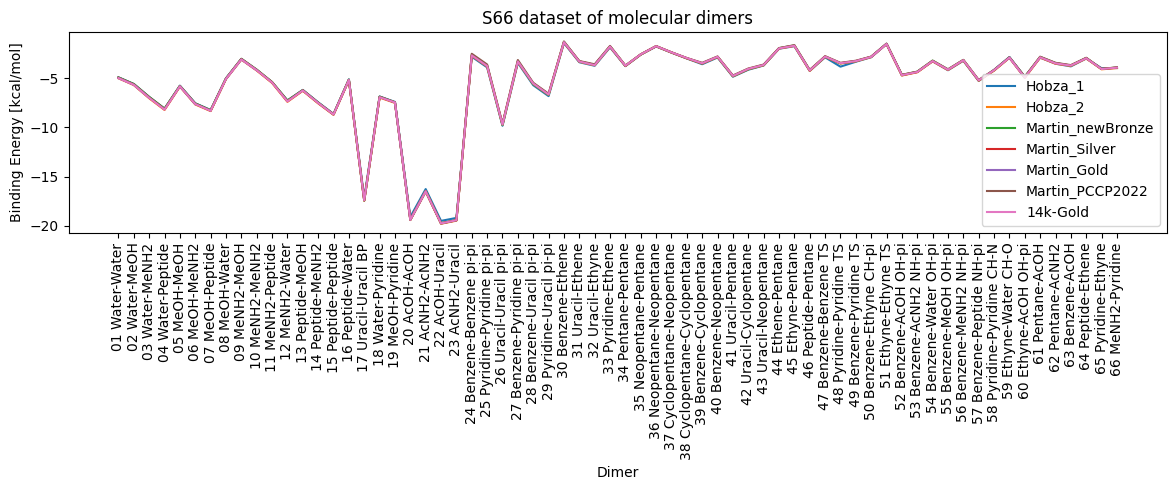

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
#fig, ax = plt.subplots()# figsize=(30,5) )
#df_refs.Hobza_1.plot( )
#df_refs.Hobza_2.plot( )
ax = df_refs.plot( xticks=range(1,67), rot=90, 
            title = 'S66 dataset of molecular dimers',
            xlabel = 'Dimer',
            ylabel = 'Binding Energy [kcal/mol]' )
ax.set_xticklabels( df_refs.name )
plt.tight_layout()
plt.savefig('Refs.png',dpi=300)
plt.rcdefaults()

Hobza_1
Hobza_2
Martin_newBronze
Martin_Silver
Martin_Gold
Martin_PCCP2022


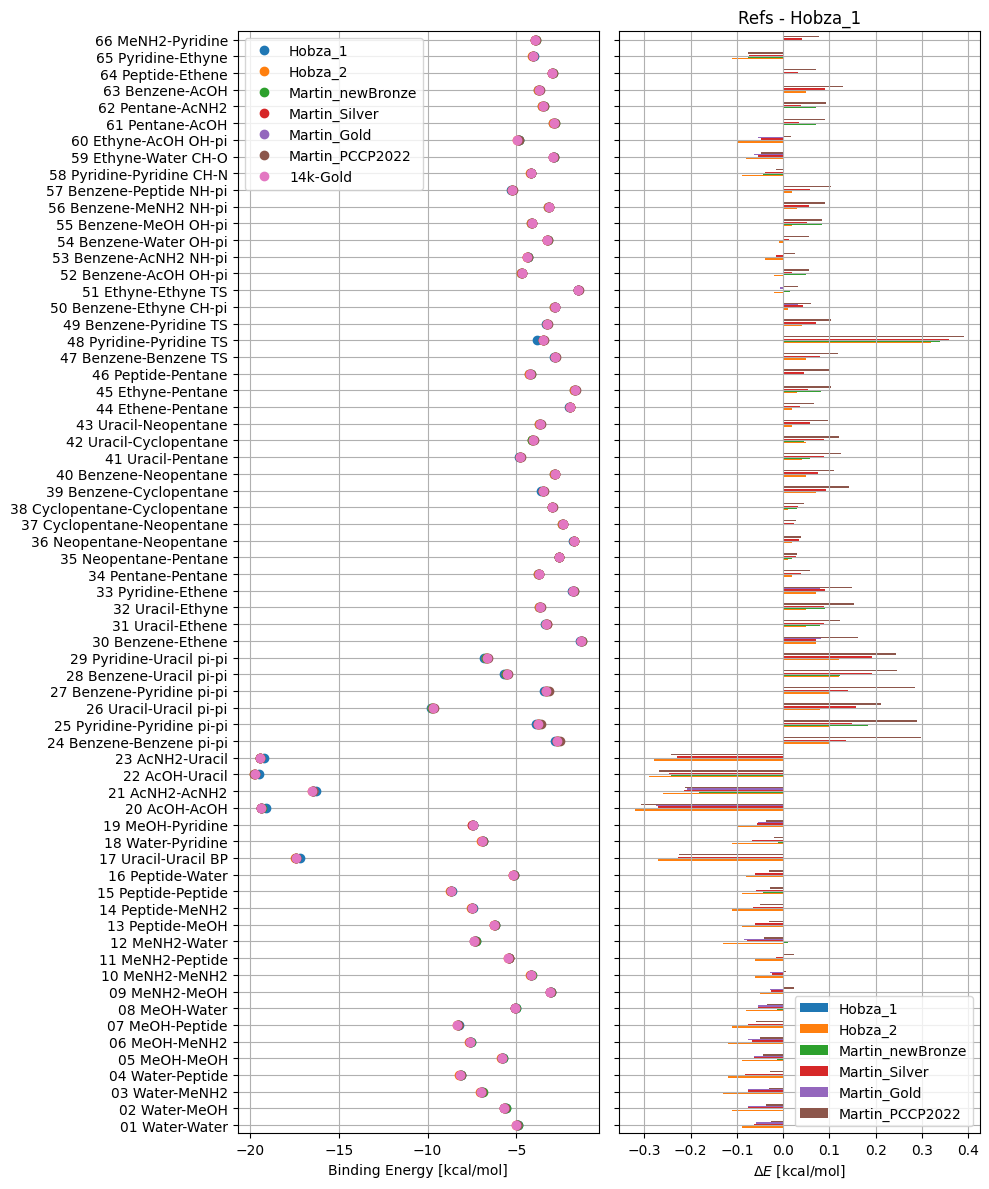

In [5]:
# Plot difference between references 

delta_refs = pd.DataFrame()
for i in df_refs.columns:
    if i.startswith('Hobza') or i.startswith('Martin_'):
#for i in [ 'Hobza_1', 'Hobza_2', 'Martin_newBronze', 'Martin_Silver' ]: 
        print(i)
        delta_refs[i] = df_refs[i] - df_refs.Hobza_1

import matplotlib.pyplot as plt
fig, (ax2,ax) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
#plt.rcParams["figure.figsize"] = (7, 12)
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Refs - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
#for ref in ['Hobza_1','Hobza_2','Martin_newBronze','Martin_Silver']:
for ref in df_refs.columns:
    if ref != 'name':
        ax2.plot( df_refs[ref], df_refs.index-1, 'o', label=ref )
ax2.set_xlabel( 'Binding Energy [kcal/mol]' )
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('Refs_delta.png',dpi=300)

plt.rcdefaults()

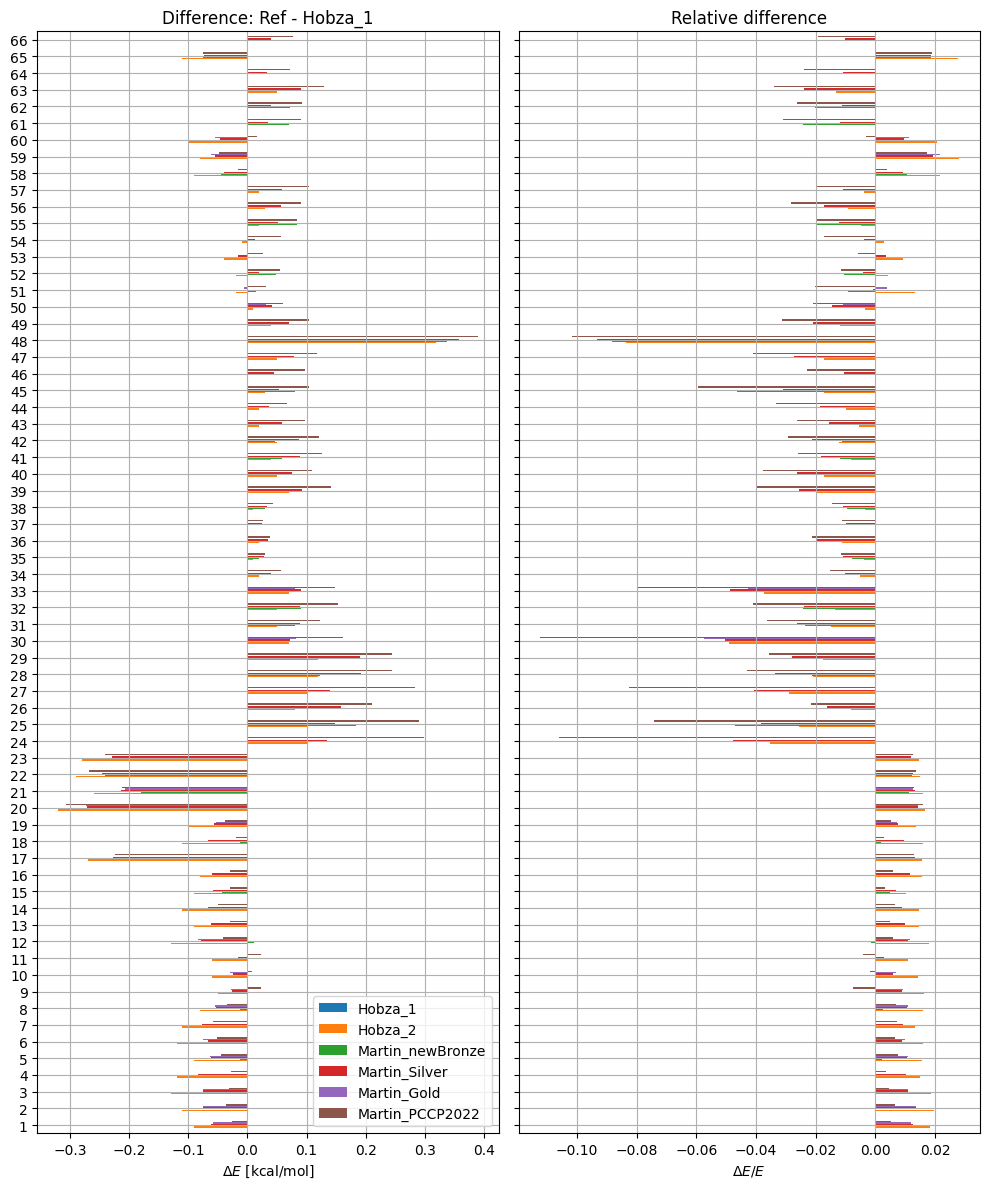

In [6]:
# Plot relative difference between references 

rdelta_refs = delta_refs.copy()
for i in delta_refs.columns:
    rdelta_refs[i] = delta_refs[i] / df_refs.Hobza_1

fig, (ax,ax2) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Difference: Ref - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
rdelta_refs.plot(kind='barh', rot=0, grid=True,
                title='Relative difference', 
                xlabel='', legend=False,
                ax=ax2)
ax2.set_xlabel( r'$\Delta E / E$ ' )

plt.tight_layout()
plt.savefig('Refs_delta_relative.png',dpi=300)

plt.rcdefaults()